### 패키지 임포트

In [ ]:
import numpy as np
import pandas as pd
import re
import spacy
import gensim
from tqdm.notebook import tqdm

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Plotting tools
#import pyLDAvis
#import pyLDAvis.lda_model # pyLDAvis 3.4.0부터 .sklearn 없어짐! 대신 .lda_model 동일 기능 사용 가능
# https://stackoverflow.com/questions/76836793/jupyter-notebook-cannot-import-pyldavis-sklearn
#import matplotlib.pyplot as plt
#%matplotlib inline


#### 문서 데이터셋 로드

In [2]:
df = pd.read_csv("./2018산림복지 본문to명사+정제.txt", sep='\t', encoding='UTF-8')
print(df.shape, df.columns)
df.head()

(4786, 4) Index(['Unnamed: 0', 'org_idx', '문서to명사', '문서to명사_정제'], dtype='object')


,Unnamed: 0,org_idx,문서to명사,문서to명사_정제
0,0,0,블로그 개 글 목록 열기 영어 명언 모음 영어 명언 모음 문장 영어 명언 적 자신 ...,개 글 목록 열기 영어 명언 모음 영어 명언 모음 문장 영어 명언 적 자신 말 줄 ...
1,1,1,인사말 인사말 장애인 날 첫 회 시작 배리어프리 영화 소개 코너 소개 코너 소개 배...,인사말 인사말 장애인 날 첫 회 시작 배리어프리 영화 소개 코너 소개 코너 소개 배...
2,2,2,블로그 게시판 개 글 게시판 목록 열기 콩 그 마취 일정 기간 지나 게시판 지난해 ...,게시판 개 글 게시판 목록 열기 콩 마취 일정 기간 지나 게시판 지난해 국가 복리 ...
3,3,3,블로그 복지 단체 자선가 개 글 복지 단체 자선가 목록 복지 단체 자선가 글 목록 ...,복지 단체 자선가 개 글 복지 단체 자선가 목록 복지 단체 자선가 글 목록 글 제목...
4,4,4,급 항만 경제 전략 국장 병수 도시 주택 국장 손정호 급 항만 정책 과장 정형민 성...,급 항만 경제 전략 국장 병수 도시 주택 국장 손정호 급 항만 정책 과장 정형민 성...


In [3]:
nouns = list(df['문서to명사_정제'])
print(len(nouns))

4786


In [4]:
find_nan = [i for i in range(len(nouns)) if type(nouns[i]) == float]
print(len(find_nan), find_nan[:10])
for idx in find_nan:
    print(nouns[idx])


0 []


In [11]:
for idx in find_nan:
    nouns[idx] = 'notext'

In [12]:
find_nan2 = [i for i in range(len(nouns)) if type(nouns[i]) == float]
print(len(find_nan2), find_nan2[:10])

0 []


#### 불용어 데이터셋 로드

In [5]:
pronoundf = pd.read_csv("./한국어 불용어 목록/한국어 대명사 목록.txt", sep='\t', encoding='UTF-8')
adverbdf = pd.read_csv("./한국어 불용어 목록/한국어 부사 목록.txt", sep='\t', encoding='UTF-8')
josadf = pd.read_csv("./한국어 불용어 목록/한국어 조사 목록.txt", sep='\t', encoding='UTF-8')
kor_pronoun = pronoundf['대명사'].to_list()
kor_adverb = adverbdf['부사'].to_list()
kor_josa = josadf['조사'].to_list()
kor_stopwords = sorted(list(set(kor_pronoun + kor_adverb + kor_josa)))
print(len(kor_stopwords), kor_stopwords[:10])


530 ['가', '가까이', '가끔', '같이', '같이나', '같이는', '같이는야', '같이는커녕', '같이도', '같이만']


#### 데이터 전처리
1. 정규표현식으로 데이터 정제 - 산림복지 이미 해서 할 필요 없음.
2. 토큰화=형태소화 및 문장부호 없애기
3. Lemmatization 표제어 추출 : am, are, is, were 의 표제어는 be

#### Document-Word matrix 만들기

In [6]:
vectorizer = CountVectorizer(analyzer='word',       
                            #  min_df=10,                         # minimum reqd occurences of a word
                             stop_words=kor_stopwords,          # remove stop words
                             lowercase=True,                    # convert all words to lowercase
                             token_pattern=r"(?u)\b\w+\b",      # num chars 1도 포함
                            )


In [7]:
data_vectorized = vectorizer.fit_transform(nouns)

#### LDA 모델 만들기

In [8]:
lda_model = LatentDirichletAllocation(n_components=20,           # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)


Exception in thread ExecutorManagerThread:
Traceback (most recent call last):
  File "c:\Users\user\anaconda3\envs\NIFOS\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "c:\Users\user\anaconda3\envs\NIFOS\lib\site-packages\joblib\externals\loky\process_executor.py", line 563, in run
    result_item, is_broken, bpe = self.wait_result_broken_or_wakeup()
  File "c:\Users\user\anaconda3\envs\NIFOS\lib\site-packages\joblib\externals\loky\process_executor.py", line 617, in wait_result_broken_or_wakeup
    ready = wait(readers + worker_sentinels)
  File "c:\Users\user\anaconda3\envs\NIFOS\lib\multiprocessing\connection.py", line 869, in wait
    ready_handles = _exhaustive_wait(waithandle_to_obj.keys(), timeout)
  File "c:\Users\user\anaconda3\envs\NIFOS\lib\multiprocessing\connection.py", line 801, in _exhaustive_wait
    res = _winapi.WaitForMultipleObjects(L, False, timeout)
ValueError: need at most 63 handles, got a sequence of length 97



In [11]:
print(lda_model)  # Model attributes

LatentDirichletAllocation(learning_method='online', n_components=20, n_jobs=-1,
                          random_state=100)


In [12]:
print(lda_output)

[[1.42226737e-02 3.24957252e-01 6.44556944e-01 ... 3.35570478e-04
  3.35570470e-04 1.08940030e-02]
 [1.59723571e-01 3.67328714e-01 5.20833349e-04 ... 5.20833347e-04
  5.20833333e-04 5.20833334e-04]
 [7.63358786e-05 7.63358791e-05 3.26929286e-02 ... 7.63358803e-05
  7.63358779e-05 7.63358784e-05]
 ...
 [3.62971727e-01 4.51216456e-01 2.27272733e-04 ... 2.27272731e-04
  2.27272739e-04 2.27272742e-04]
 [5.74712648e-04 5.63227313e-01 3.31794090e-01 ... 5.74712648e-04
  5.74712646e-04 5.74712646e-04]
 [1.04862800e-02 5.67536904e-05 1.87504441e-02 ... 3.74119463e-01
  5.67536890e-05 2.20773364e-02]]


#### Perplexity와 Log-likelihood로 모델 성능 진단

In [13]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -48010646.92498084
Perplexity:  2942.573243365057
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 20,
 'n_jobs': -1,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


#### 최고 성능 LDA 모델 GridSearch

In [ ]:
# Define Search Param
search_params = {'n_components': [5, 10, 15, 20], 'learning_decay': [.5, .7, .9]}

# Init the Model
# lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda_model, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

GridSearchCV(estimator=LatentDirichletAllocation(learning_method='online',
                                                 n_components=20, n_jobs=-1,
                                                 random_state=100),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [5, 10, 15, 20]})

#### 가장 성능이 뛰어난 토픽 모델의 파라미터 확인하기

In [ ]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.5, 'n_components': 10}
Best Log Likelihood Score:  -10383755.526617577
Model Perplexity:  3286.88022194986


## 모델 저장하기

In [ ]:
import pickle

# 저장할 파일의 이름 설정
with open('./lda_model_18', 'wb') as f:
    pickle.dump(best_lda_model, f)

#### LDA 모델 성능 비교

In [16]:
#### numpy 출력 결과 생략 없이 전부 출력 설정 코드
# np.set_printoptions(threshold=np.inf, linewidth=np.inf)

In [17]:
# print(model.cv_results_)
model.cv_results_


{'mean_fit_time': array([ 63.17696819, 112.43952556, 181.24137006, 229.86391449,
         63.07568102, 114.73521414, 172.97581277, 232.94630957,
         66.58519788, 119.51869478, 174.313234  , 227.66070137]),
 'std_fit_time': array([ 6.35186886,  7.79190206,  3.68871255, 12.23177749,  4.36977521,
         1.74649797,  7.5861024 , 12.42777784,  4.35232373,  5.03309255,
         1.68990044,  7.06597042]),
 'mean_score_time': array([0.50764775, 0.49109235, 0.71639137, 0.84651842, 0.40890641,
        0.53956919, 0.74920239, 0.72027407, 0.43563342, 0.57686439,
        0.62014704, 1.08470659]),
 'std_score_time': array([0.15436279, 0.0290265 , 0.20257715, 0.26185872, 0.01042201,
        0.03711732, 0.19258763, 0.08066785, 0.02237549, 0.06489134,
        0.02794404, 0.42458491]),
 'param_learning_decay': masked_array(data=[0.5, 0.5, 0.5, 0.5, 0.7, 0.7, 0.7, 0.7, 0.9, 0.9, 0.9,
                    0.9],
              mask=[False, False, False, False, False, False, False, False,
             

In [18]:
for g_score in model.cv_results_:
    if g_score == 'mean_test_score':
        print('{} 값:'.format(g_score), model.cv_results_[g_score])
    elif g_score == 'params':
        for i in range(len(model.cv_results_[g_score])):
            print('인덱스는 {} :'.format(i), model.cv_results_[g_score][i])


인덱스는 0 : {'learning_decay': 0.5, 'n_components': 5}
인덱스는 1 : {'learning_decay': 0.5, 'n_components': 10}
인덱스는 2 : {'learning_decay': 0.5, 'n_components': 15}
인덱스는 3 : {'learning_decay': 0.5, 'n_components': 20}
인덱스는 4 : {'learning_decay': 0.7, 'n_components': 5}
인덱스는 5 : {'learning_decay': 0.7, 'n_components': 10}
인덱스는 6 : {'learning_decay': 0.7, 'n_components': 15}
인덱스는 7 : {'learning_decay': 0.7, 'n_components': 20}
인덱스는 8 : {'learning_decay': 0.9, 'n_components': 5}
인덱스는 9 : {'learning_decay': 0.9, 'n_components': 10}
인덱스는 10 : {'learning_decay': 0.9, 'n_components': 15}
인덱스는 11 : {'learning_decay': 0.9, 'n_components': 20}
mean_test_score 값: [-10396768.12684235 -10383755.52661758 -10420564.57900178
 -10441001.79282834 -10405481.98286564 -10391740.55576397
 -10418928.21012216 -10456692.40262006 -10431208.61943822
 -10420808.35876803 -10459671.87596243 -10503607.98102266]


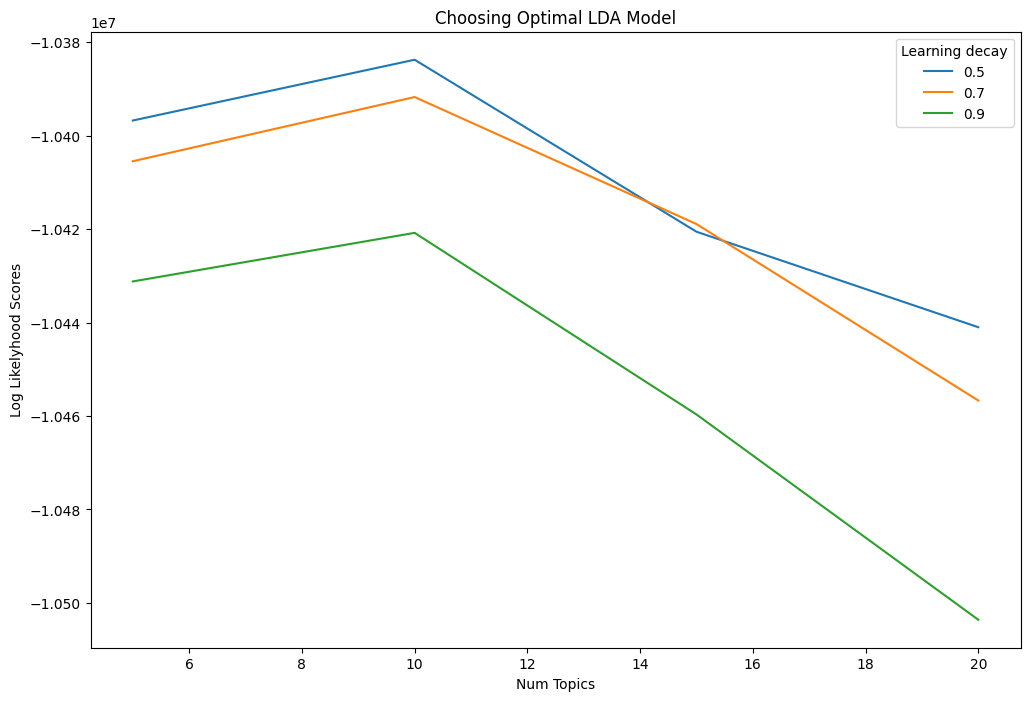

In [19]:
# Get Log Likelyhoods from Grid Search Output
n_topics = [5, 10, 15, 20]
log_likelyhoods_5 = [round(model.cv_results_['mean_test_score'][i]) for i in range(0,4)]
log_likelyhoods_7 = [round(model.cv_results_['mean_test_score'][i]) for i in range(4,8)]
log_likelyhoods_9 = [round(model.cv_results_['mean_test_score'][i]) for i in range(8,12)]

# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

#### 개별 문서의 주요 토픽 파악

In [20]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(nouns))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
Doc0,0.060000,0.320000,0.450000,0.000000,0.000000,0.160000,0.000000,0.000000,0.000000,0.000000,2
Doc1,0.480000,0.320000,0.000000,0.080000,0.040000,0.000000,0.000000,0.070000,0.000000,0.000000,0
Doc2,0.010000,0.030000,0.030000,0.000000,0.000000,0.010000,0.730000,0.170000,0.000000,0.000000,6
Doc3,0.010000,0.000000,0.270000,0.000000,0.000000,0.070000,0.000000,0.010000,0.000000,0.640000,9
Doc4,0.000000,0.950000,0.000000,0.000000,0.000000,0.050000,0.000000,0.000000,0.000000,0.000000,1
Doc5,0.120000,0.170000,0.010000,0.140000,0.030000,0.000000,0.000000,0.500000,0.020000,0.010000,7
Doc6,0.030000,0.040000,0.000000,0.010000,0.040000,0.120000,0.030000,0.690000,0.000000,0.040000,7
Doc7,0.540000,0.060000,0.000000,0.120000,0.020000,0.000000,0.020000,0.130000,0.110000,0.000000,0
Doc8,0.650000,0.050000,0.000000,0.080000,0.000000,0.000000,0.000000,0.050000,0.170000,0.000000,0
Doc9,0.020000,0.000000,0.000000,0.000000,0.040000,0.040000,0.000000,0.060000,0.000000,0.830000,9


#### 문서의 토픽 분포 파악

In [21]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,1,3707
1,0,1829
2,2,932
3,4,750
4,7,659
5,6,562
6,9,308
7,5,291
8,8,129
9,3,126


#### pyLDAvis로 LDA 모델 시각화하기

In [22]:
import pyLDAvis.lda_model
pyLDAvis.enable_notebook()
panel = pyLDAvis.lda_model.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\sparse\_sputils.py:44: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  upcast = np.find_common_type(args, [])
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\sparse\_sputils.py:44: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  upcast = np.find_common_type(args, [])


PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
1      51.258137  24.659700       1        1  18.414770
0      -7.014673 -40.031170       2        1  14.851239
4      19.910448  14.611925       3        1  13.963469
7     -19.313387  27.173986       4        1  13.148520
6      13.757512  46.694561       5        1  11.021677
2      -5.605068  -4.308619       6        1   8.838550
8     -37.003002 -11.706769       7        1   6.120410
3      31.627884 -48.413563       8        1   4.865612
5      23.589628 -16.950916       9        1   4.481942
9      56.657135 -12.698343      10        1   4.293812, topic_info=      Term          Freq         Total Category  logprob  loglift
71302   학과  12751.000000  12751.000000  Default  30.0000  30.0000
31150   산림  40240.000000  40240.000000  Default  29.0000  29.0000
59760   지원  24986.000000  24986.000000  Default  28.0000  28.0000
36782    숲  24489.000000  24489.000000  Default  27.0000  27.0000
71355   학부   8414.000000   8414.000000  Default  26.0000  26.0000
...    ...           ...           ...      ...      ...      ...
37937  시스템   1897.115116   5378.859002  Topic10  -4.9130   2.1059
52519   일반   1926.994577   7876.066345  Topic10  -4.8974   1.7401
59721   지역   2107.350910  24942.707389  Topic10  -4.8079   0.6768
52220   인원   1464.181872   3690.594776  Topic10  -5.1721   2.2235
69233   평균   1389.000312   2930.683834  Topic10  -5.2248   2.4013

[790 rows x 6 columns], token_table=       Topic      Freq   Term
term                         
310        5  0.997827     가액
385        1  0.069183     가장
385        2  0.158966     가장
385        3  0.007773     가장
385        4  0.536755     가장
...      ...       ...    ...
76040      1  0.030438    휴양림
76040      2  0.951603    휴양림
76040      6  0.017622    휴양림
76227      8  0.994830     흥덕
76443      8  0.991875  힐스테이트

[2128 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 5, 8, 7, 3, 9, 4, 6, 10])

#### 토픽의 키워드 출력

In [23]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names_out()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

,notext,가가,가가린,가가호호,가각,가감,가갸날,가거도,가건물,가게,...,힘쎈테크툴,힘일,힘줄,힘진,힙,힙니,힙합,힛,힛포,힝
Topic0,0.1,67.227879,0.100019,1.826110,0.100138,0.100148,0.100246,9.975139,0.100152,261.470511,...,0.100072,0.100380,0.100006,0.100091,6.974357,0.100031,0.100392,0.100249,0.100107,2.522495
Topic1,0.1,25.604805,0.100016,0.100108,0.100004,0.100115,0.100118,0.100014,0.100017,54.903235,...,0.100000,0.100022,0.100006,0.100009,0.100051,0.100018,5.699192,0.100000,0.100006,0.100007
Topic2,0.1,0.100029,0.100003,0.100018,0.100012,0.100699,0.100200,0.100003,0.100017,0.100112,...,0.100004,0.100005,0.100009,0.100025,0.100004,0.100001,0.100061,0.100022,0.100005,0.100009
Topic3,0.1,0.100033,0.100025,8.403970,0.100076,0.100568,0.100000,0.100232,0.100636,0.100020,...,0.100203,1.993694,0.100004,0.100247,0.100036,0.100003,0.100127,0.886048,0.100028,0.100008
Topic4,0.1,0.100046,0.100027,0.100012,0.100011,0.100177,0.100032,0.100009,0.100148,31.695419,...,1.221620,0.100318,0.100041,0.100079,0.100052,0.100023,0.100023,0.100000,0.100008,0.100003


#### 각 토픽의 키워드 15개 추출

In [24]:
# Define function to predict topic for a given text document.

def predict_topic(text):
    # Vectorize transform
    mytext_2 = vectorizer.transform(text)

    # LDA Transform
    topic_probability_scores = best_lda_model.transform(mytext_2)
    topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), :].values.tolist()
    return topic, topic_probability_scores

# Predict the topic
mytext = ["한겨울 추위를 뚫고 피어난 복수초를 보러 홍릉수목원에 다녀왔어요."]
topic, prob_scores = predict_topic(text = mytext)
print(topic)

[0.10000000116556236, 67.22787948386544, 0.10001934568518223, 1.8261103369922111, 0.10013812690502677, 0.10014776826920761, 0.10024645586609485, 9.975139164648995, 0.10015169600001785, 261.47051145808797, 0.10014222051175024, 503.52733565551614, 0.1000232102220829, 0.10000046525544284, 0.10002055073458431, 0.10000226570473754, 27.363100615855025, 0.10005401891922094, 0.10001349622028836, 0.10000131844666228, 0.10000366532189758, 0.10009101426330104, 0.10002651276709505, 0.10077968762313191, 0.10000156833201004, 0.10018400424083614, 0.10000415755533863, 0.10004002162720728, 0.10004181497130774, 0.10000738052532376, 0.10003037363030562, 0.1000259636662989, 0.10000107254198554, 0.10000277450054715, 62.07542591810221, 0.10037528529657655, 0.10002153274106512, 0.10007521592445874, 0.10002864431381998, 0.10000001167350955, 0.10028659886588182, 1.2822486389371721, 0.10000007046097752, 0.10000014165113852, 0.10001030360316833, 0.10013949589647977, 0.10001667283173016, 0.10007135831332614, 0.10

#### 유사한 토픽과 plot을 가진 문서 군집 분석

In [25]:
# Construct the k-means clusters
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=15, random_state=100).fit_predict(lda_output)

# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Component's weights: 
 [[ 0.38  0.89  0.13  0.05  0.13  0.05  0.07  0.11  0.08  0.01]
 [ 0.92 -0.39 -0.01  0.02 -0.04 -0.    0.01  0.09  0.    0.  ]]
Perc of Variance Explained: 
 [0.17 0.29]


Text(0.5, 1.0, 'Segregation of Topic Clusters')

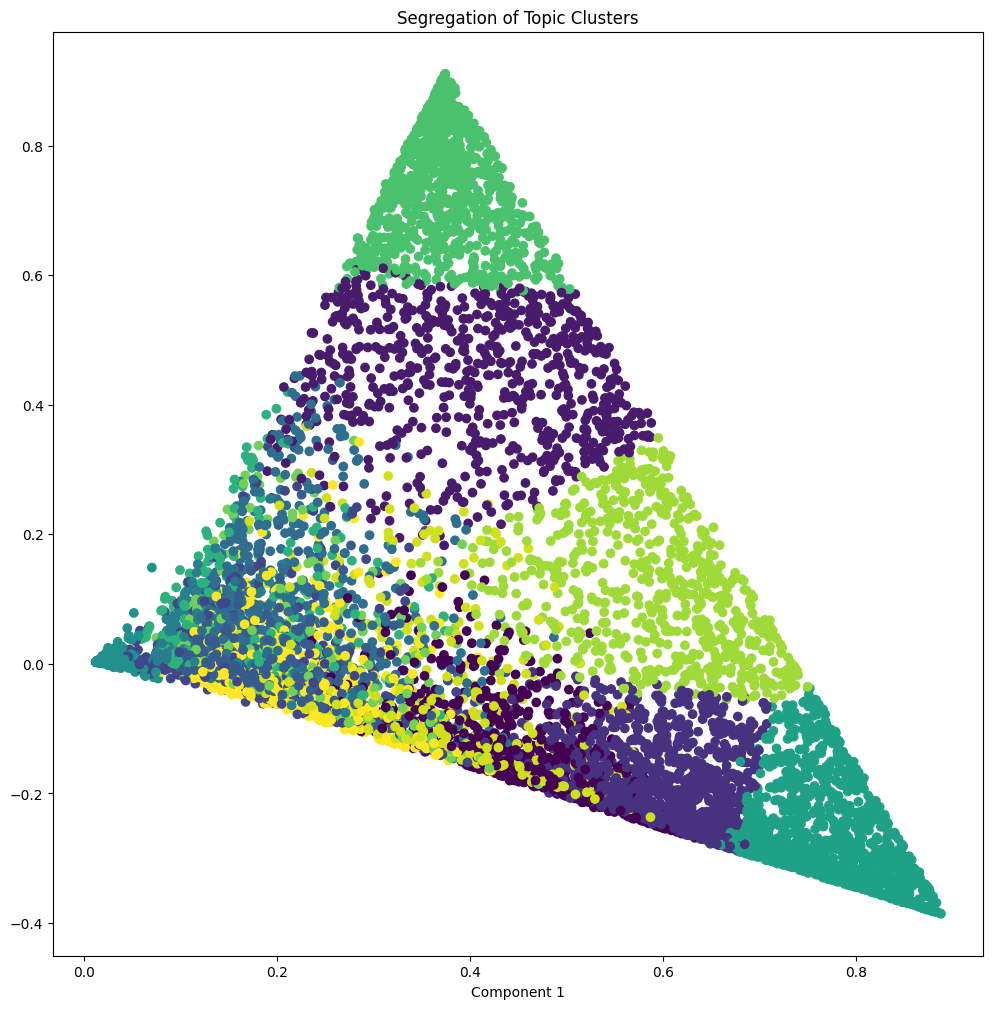

In [26]:
# Plot
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )

#### 주어진 텍스트와 유사한 문서 분석

In [27]:
from sklearn.metrics.pairwise import euclidean_distances

# nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

def similar_documents(text, doc_topic_probs, documents = nouns, top_n=5, verbose=False):
    topic, x  = predict_topic(text)
    dists = euclidean_distances(x.reshape(1, -1), doc_topic_probs)[0]
    doc_ids = np.argsort(dists)[:top_n]
    if verbose:        
        # print("Topic KeyWords: ", topic)
        print("Topic Prob Scores of text: ", np.round(x, 1))
        print("Most Similar Doc's Probs:  ", np.round(doc_topic_probs[doc_ids], 1))
    return doc_ids, np.take(documents, doc_ids)

In [28]:
# Get similar documents
mytext = ["한겨울 추위를 뚫고 피어난 복수초를 보러 홍릉수목원에 다녀왔어요."]
doc_ids, docs = similar_documents(text=mytext, doc_topic_probs=lda_output, documents = nouns, top_n=1, verbose=True)
print('\n', docs[0][:500])

Topic Prob Scores of text:  [[0.5 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]]
Most Similar Doc's Probs:   [[0.5 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]]

 하하


In [29]:
df_document_topic.head()

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
Doc0,0.06,0.32,0.45,0.00,0.00,0.16,0.00,0.00,0.0,0.00,2
Doc1,0.48,0.32,0.00,0.08,0.04,0.00,0.00,0.07,0.0,0.00,0
Doc2,0.01,0.03,0.03,0.00,0.00,0.01,0.73,0.17,0.0,0.00,6
Doc3,0.01,0.00,0.27,0.00,0.00,0.07,0.00,0.01,0.0,0.64,9
Doc4,0.00,0.95,0.00,0.00,0.00,0.05,0.00,0.00,0.0,0.00,1


In [30]:
df_topic_keywords_t = df_topic_keywords.T
df_topic_keywords_t


,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9
notext,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,45.510651,0.100000,0.100000
가가,67.227879,25.604805,0.100029,0.100033,0.100046,0.100150,70.209082,0.100067,0.100036,0.100474
가가린,0.100019,0.100016,0.100003,0.100025,0.100027,0.100014,0.100013,6.348011,0.100005,0.100004
가가호호,1.826110,0.100108,0.100018,8.403970,0.100012,0.100007,0.100012,0.100050,0.100042,0.100001
가각,0.100138,0.100004,0.100012,0.100076,0.100011,0.100030,2.410700,0.100469,0.100047,0.100002
...,...,...,...,...,...,...,...,...,...,...
힙니,0.100031,0.100018,0.100001,0.100003,0.100023,0.100011,0.100003,1.285579,0.100005,0.100004
힙합,0.100392,5.699192,0.100061,0.100127,0.100023,0.100096,0.100002,0.100080,0.100092,0.100010
힛,0.100249,0.100000,0.100022,0.886048,0.100000,0.100000,0.100002,0.100018,0.100050,0.100000
힛포,0.100107,0.100006,0.100005,0.100028,0.100008,0.100031,0.100007,0.552750,0.100003,0.100003


In [31]:
df_topic_keywords_t.to_csv("D:/2022산림복지 GridSearch-LDA 토픽모델링.txt", sep='\t', encoding='UTF-8')

In [3]:
import pandas as pd
df_topic_keywords_t = pd.read_csv("D:/2022산림복지 GridSearch-LDA 토픽모델링.txt", sep='\t', encoding='UTF-8')
df_topic_keywords_t.head()


,Unnamed: 0,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9
0,notext,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,45.510651,0.100000,0.100000
1,가가,67.227879,25.604805,0.100029,0.100033,0.100046,0.100150,70.209082,0.100067,0.100036,0.100474
2,가가린,0.100019,0.100016,0.100003,0.100025,0.100027,0.100014,0.100013,6.348011,0.100005,0.100004
3,가가호호,1.826110,0.100108,0.100018,8.403970,0.100012,0.100007,0.100012,0.100050,0.100042,0.100001
4,가각,0.100138,0.100004,0.100012,0.100076,0.100011,0.100030,2.410700,0.100469,0.100047,0.100002


In [9]:
topic0DF = df_topic_keywords_t[['Unnamed: 0', 'Topic0']]
topic0DF.sort_values(by='Topic0', inplace=True, ascending=False)
topic0_top20 = topic0DF.head(20)
topic0_top20.reset_index(inplace=True)
topic0_top20.columns = ['idx', '단어0', 'Topic0']
topic0_top20.reset_index(inplace=True)
# topic0_top20 = topic0_top20[['index', '단어0', 'Topic0']]
# topic0_top20

topic1DF = df_topic_keywords_t[['Unnamed: 0', 'Topic1']]
topic1DF.sort_values(by='Topic1', inplace=True, ascending=False)
topic1_top20 = topic1DF.head(20)
topic1_top20.reset_index(inplace=True)
topic1_top20.columns = ['idx', '단어1', 'Topic1']
topic1_top20.reset_index(inplace=True)

topic2DF = df_topic_keywords_t[['Unnamed: 0', 'Topic2']]
topic2DF.sort_values(by='Topic2', inplace=True, ascending=False)
topic2_top20 = topic2DF.head(20)
topic2_top20.reset_index(inplace=True)
topic2_top20.columns = ['idx', '단어2', 'Topic2']
topic2_top20.reset_index(inplace=True)

topic3DF = df_topic_keywords_t[['Unnamed: 0', 'Topic3']]
topic3DF.sort_values(by='Topic3', inplace=True, ascending=False)
topic3_top20 = topic3DF.head(20)
topic3_top20.reset_index(inplace=True)
topic3_top20.columns = ['idx', '단어3', 'Topic3']
topic3_top20.reset_index(inplace=True)

topic4DF = df_topic_keywords_t[['Unnamed: 0', 'Topic4']]
topic4DF.sort_values(by='Topic4', inplace=True, ascending=False)
topic4_top20 = topic4DF.head(20)
topic4_top20.reset_index(inplace=True)
topic4_top20.columns = ['idx', '단어4', 'Topic4']
topic4_top20.reset_index(inplace=True)

topic5DF = df_topic_keywords_t[['Unnamed: 0', 'Topic5']]
topic5DF.sort_values(by='Topic5', inplace=True, ascending=False)
topic5_top20 = topic5DF.head(20)
topic5_top20.reset_index(inplace=True)
topic5_top20.columns = ['idx', '단어5', 'Topic5']
topic5_top20.reset_index(inplace=True)

topic6DF = df_topic_keywords_t[['Unnamed: 0', 'Topic6']]
topic6DF.sort_values(by='Topic6', inplace=True, ascending=False)
topic6_top20 = topic6DF.head(20)
topic6_top20.reset_index(inplace=True)
topic6_top20.columns = ['idx', '단어6', 'Topic6']
topic6_top20.reset_index(inplace=True)

topic7DF = df_topic_keywords_t[['Unnamed: 0', 'Topic7']]
topic7DF.sort_values(by='Topic7', inplace=True, ascending=False)
topic7_top20 = topic7DF.head(20)
topic7_top20.reset_index(inplace=True)
topic7_top20.columns = ['idx', '단어7', 'Topic7']
topic7_top20.reset_index(inplace=True)

topic8DF = df_topic_keywords_t[['Unnamed: 0', 'Topic8']]
topic8DF.sort_values(by='Topic8', inplace=True, ascending=False)
topic8_top20 = topic8DF.head(20)
topic8_top20.reset_index(inplace=True)
topic8_top20.columns = ['idx', '단어8', 'Topic8']
topic8_top20.reset_index(inplace=True)

topic9DF = df_topic_keywords_t[['Unnamed: 0', 'Topic9']]
topic9DF.sort_values(by='Topic9', inplace=True, ascending=False)
topic9_top20 = topic9DF.head(20)
topic9_top20.reset_index(inplace=True)
topic9_top20.columns = ['idx', '단어9', 'Topic9']
topic9_top20.reset_index(inplace=True)



C:\Users\user\AppData\Local\Temp\ipykernel_7288\857589711.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic0DF.sort_values(by='Topic0', inplace=True, ascending=False)
C:\Users\user\AppData\Local\Temp\ipykernel_7288\857589711.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic1DF.sort_values(by='Topic1', inplace=True, ascending=False)
C:\Users\user\AppData\Local\Temp\ipykernel_7288\857589711.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

In [2]:
topic0DF = df_topic_keywords_t[['Topic0']]
topic0DF.sort_values(by='Topic0', inplace=True, ascending=False)
topic0_top20 = topic0DF.head(20)
topic0_top20.reset_index(inplace=True)
topic0_top20.columns = ['단어0', 'Topic0']
topic0_top20.reset_index(inplace=True)

topic1DF = df_topic_keywords_t[['Topic1']]
topic1DF.sort_values(by='Topic1', inplace=True, ascending=False)
topic1_top20 = topic1DF.head(20)
topic1_top20.reset_index(inplace=True)
topic1_top20.columns = ['단어1', 'Topic1']
topic1_top20.reset_index(inplace=True)

topic2DF = df_topic_keywords_t[['Topic2']]
topic2DF.sort_values(by='Topic2', inplace=True, ascending=False)
topic2_top20 = topic2DF.head(20)
topic2_top20.reset_index(inplace=True)
topic2_top20.columns = ['단어2', 'Topic2']
topic2_top20.reset_index(inplace=True)

topic3DF = df_topic_keywords_t[['Topic3']]
topic3DF.sort_values(by='Topic3', inplace=True, ascending=False)
topic3_top20 = topic3DF.head(20)
topic3_top20.reset_index(inplace=True)
topic3_top20.columns = ['단어3', 'Topic3']
topic3_top20.reset_index(inplace=True)

topic4DF = df_topic_keywords_t[['Topic4']]
topic4DF.sort_values(by='Topic4', inplace=True, ascending=False)
topic4_top20 = topic4DF.head(20)
topic4_top20.reset_index(inplace=True)
topic4_top20.columns = ['단어4', 'Topic4']
topic4_top20.reset_index(inplace=True)

topic5DF = df_topic_keywords_t[['Topic5']]
topic5DF.sort_values(by='Topic5', inplace=True, ascending=False)
topic5_top20 = topic5DF.head(20)
topic5_top20.reset_index(inplace=True)
topic5_top20.columns = ['단어5', 'Topic5']
topic5_top20.reset_index(inplace=True)

topic6DF = df_topic_keywords_t[['Topic6']]
topic6DF.sort_values(by='Topic6', inplace=True, ascending=False)
topic6_top20 = topic6DF.head(20)
topic6_top20.reset_index(inplace=True)
topic6_top20.columns = ['단어6', 'Topic6']
topic6_top20.reset_index(inplace=True)

topic7DF = df_topic_keywords_t[['Topic7']]
topic7DF.sort_values(by='Topic7', inplace=True, ascending=False)
topic7_top20 = topic7DF.head(20)
topic7_top20.reset_index(inplace=True)
topic7_top20.columns = ['단어7', 'Topic7']
topic7_top20.reset_index(inplace=True)

topic8DF = df_topic_keywords_t[['Topic8']]
topic8DF.sort_values(by='Topic8', inplace=True, ascending=False)
topic8_top20 = topic8DF.head(20)
topic8_top20.reset_index(inplace=True)
topic8_top20.columns = ['단어8', 'Topic8']
topic8_top20.reset_index(inplace=True)

topic9DF = df_topic_keywords_t[['Topic9']]
topic9DF.sort_values(by='Topic9', inplace=True, ascending=False)
topic9_top20 = topic9DF.head(20)
topic9_top20.reset_index(inplace=True)
topic9_top20.columns = ['단어9', 'Topic9']
topic9_top20.reset_index(inplace=True)


C:\Users\user\AppData\Local\Temp\ipykernel_7288\1209135256.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic0DF.sort_values(by='Topic0', inplace=True, ascending=False)
C:\Users\user\AppData\Local\Temp\ipykernel_7288\1209135256.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic1DF.sort_values(by='Topic1', inplace=True, ascending=False)
C:\Users\user\AppData\Local\Temp\ipykernel_7288\1209135256.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returnin

,index,단어0,Topic0,index,단어1,Topic1,index,단어2,Topic2,index,...,Topic6,index,단어7,Topic7,index,단어8,Topic8,index,단어9,Topic9
0,0,36782,10233.486511,0,31150,32479.092160,0,59760,15473.468442,0,...,10012.295123,0,30522,8293.405741,0,27202,9303.781293,0,71302,10692.347709
1,1,4155,10038.690834,1,30767,16173.735715,1,38811,13176.837706,1,...,8596.774732,1,19886,6053.278125,1,2837,7177.999481,1,71355,7277.651419
2,2,8369,7491.117757,2,27742,15721.061509,2,27742,7140.934687,2,...,7100.385840,2,34194,4511.822121,2,27125,7007.981719,2,55251,5851.338404
3,3,62521,5463.638405,3,64205,14165.617259,3,7830,7092.087346,3,...,6531.421505,3,32466,4224.285956,3,34441,5946.185030,3,55795,4962.042312
4,4,43432,4655.426876,4,36782,14076.265374,4,59932,5211.250586,4,...,6505.378546,4,17306,4031.715060,4,64099,4933.665220,4,71368,4576.060036
5,5,10664,4516.640169,5,59721,12291.323007,5,61418,5007.282181,5,...,6416.050632,5,22560,3637.478884,5,2839,3988.372370,5,28134,4525.623955
6,6,31066,4464.003798,6,48076,9572.822158,6,31150,4559.081390,6,...,6057.117833,6,52404,3482.286320,6,2908,3958.697913,6,14648,4008.162752
7,7,36784,4295.369759,7,31206,8126.610894,7,7917,4543.013237,7,...,5974.883503,7,14667,3185.365745,7,4396,3617.168435,7,21379,3568.877624
8,8,37742,3775.014206,8,5465,7567.690411,8,56041,4288.745903,8,...,4991.286726,8,31029,2953.391188,8,8369,3527.809703,8,53557,3440.195172
9,9,6153,3500.904579,9,47042,7323.722589,9,21379,4169.930469,9,...,4579.405090,9,58906,2891.934275,9,55319,3445.307925,9,5465,3194.501330


In [10]:
topicDF = pd.concat([topic0_top20, topic1_top20, topic2_top20, topic3_top20, topic4_top20, topic5_top20, topic6_top20, topic7_top20, topic8_top20, topic9_top20], axis=1)
topicDF


,index,idx,단어0,Topic0,index,idx,단어1,Topic1,index,idx,...,단어7,Topic7,index,idx,단어8,Topic8,index,idx,단어9,Topic9
0,0,36782,숲,10233.486511,0,31150,산림,32479.092160,0,59760,...,사람,8293.405741,0,27202,보건소,9303.781293,0,71302,학과,10692.347709
1,1,4155,곳,10038.690834,1,30767,사업,16173.735715,1,38811,...,말,6053.278125,1,2837,경기도,7177.999481,1,71355,학부,7277.651419
2,2,8369,길,7491.117757,2,27742,복지,15721.061509,2,27742,...,세계,4511.822121,2,27125,병원,7007.981719,2,55251,전공,5851.338404
3,3,62521,체험,5463.638405,3,64205,치유,14165.617259,3,7830,...,생각,4224.285956,3,34441,센터,5946.185030,3,55795,전형,4962.042312
4,4,43432,여행,4655.426876,4,36782,숲,14076.265374,4,59932,...,때문,4031.715060,4,64099,층,4933.665220,4,71368,학생,4576.060036
5,5,10664,나무,4516.640169,5,59721,지역,12291.323007,5,61418,...,문제,3637.478884,5,2839,경남,3988.372370,5,28134,부,4525.623955
6,6,31066,산,4464.003798,6,48076,위해,9572.822158,6,31150,...,일,3482.286320,6,2908,경북,3958.697913,6,14648,대학,4008.162752
7,7,36784,숲길,4295.369759,7,31206,산불,8126.610894,7,7917,...,대한,3185.365745,7,4396,공원,3617.168435,7,21379,모집,3568.877624
8,8,37742,시간,3775.014206,8,5465,교육,7567.690411,8,56041,...,사회,2953.391188,8,8369,길,3527.809703,8,53557,자연,3440.195172
9,9,6153,국립,3500.904579,9,47042,운영,7323.722589,9,21379,...,중,2891.934275,9,55319,전남,3445.307925,9,5465,교육,3194.501330


In [11]:
topicDF.to_csv("D:/2018-22산림복지/2022산림복지 GridSearch-LDA 1차.txt", sep='\t', encoding='UTF-8')
topicDF.to_excel("D:/2018-22산림복지/2022산림복지 GridSearch-LDA 1차.xlsx")
